IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import random
import os
import re
import string
import warnings
import cv2
import email
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from imutils import paths
from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from wordcloud import WordCloud

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, 
                                     Flatten, Dense)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

warnings.filterwarnings('ignore')
np.random.seed(49)

LOADING DATA

In [2]:
easy_ham_path = "E:/ML package/spam_ham dataset/easy_ham/easy_ham/"
hard_ham_path = "E:/ML package/spam_ham dataset/hard_ham/hard_ham/"
spam_path = "E:/ML package/spam_ham dataset/spam_2/spam_2/"

In [3]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        file_path = os.path.join(path, file)
        #f = open(path+file, encoding = "ISO-8859-1")
        with open(file_path, encoding="ISO-8859-1") as f:
            words_list = f.read()
            data.append(words_list)
        #f.close()
    return data

In [4]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

In [5]:
np.random.shuffle(ham)
np.random.shuffle(spam)


In [6]:
print(spam[49])

From fork-admin@xent.com  Thu Jul 18 10:13:14 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 19AC643F90
	for <jm@localhost>; Thu, 18 Jul 2002 05:13:14 -0400 (EDT)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Thu, 18 Jul 2002 10:13:14 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g6I97uJ10769 for <jm@jmason.org>;
    Thu, 18 Jul 2002 10:07:58 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id A48E42940A6; Thu, 18 Jul 2002 01:57:40 -0700 (PDT)
Delivered-To: fork@spamassassin.taint.org
Received: from $domain (unknown [61.57.28.53]) by xent.com (Postfix) with
    SMTP id 7D4ED294098 for <fork@xent.com>; Thu, 18 Jul 2002 01:57:34 -0700
    (PDT)
Reply-To: fork@sp

DATA PREPROCESSING

In [7]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class email_to_clean_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))

                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)  
                        break
            
            else:
                body = b.get_payload(decode=True) # get body of email
            
            soup = BeautifulSoup(body, "html.parser") #get text from body (HTML/text)
            text = soup.get_text().lower()
           
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #remove links
           
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE) #remove email addresses
            
            text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation

            text = ''.join([i for i in text if not i.isdigit()]) # remove digits

            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words] # remove stop words
            
            words_list = [lemmatizer.lemmatize(w) for w in words_list] #lemmatization
            
            words_list = [stemmer.stem(w) for w in words_list] #Stemming
            text_list.append(' '.join(words_list))
        return text_list

In [ ]:
import email
import string
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk import ngrams

# Make sure to download necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class EmailToCleanText(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None): 
        return self

    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""

            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))

                    # Skip any text/plain (txt) attachments
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True).decode('utf-8')  
                        break
            else:
                body = b.get_payload(decode=True).decode('utf-8')  
            
            # Extract text from the email body
            soup = BeautifulSoup(body, "html.parser")
            text = soup.get_text().lower()
            
            # Remove URLs
            text = re.sub(r'(https?://[^\s]+)', '', text)
            # Remove email addresses
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
            # Remove punctuation
            text = text.translate(str.maketrans('', '', string.punctuation))
            # Remove digits
            text = ''.join([char for char in text if not char.isdigit()])

            # Tokenization
            words_list = nltk.word_tokenize(text)
            # Remove stop words
            words_list = [w for w in words_list if w not in self.stop_words]
            # Handle negation (simple approach)
            words_list = [self.handle_negations(word) for word in words_list]

            # Lemmatization
            words_list = [lemmatizer.lemmatize(w) for w in words_list]
            # Stemming
            words_list = [stemmer.stem(w) for w in words_list]
            

            text_list.append(' '.join(words_list))
        return text_list

    def handle_negations(self, word):
        """Simple function to handle negations."""
        negations = ["not", "no", "never", "none", "neither", "nobody"]
        if word in negations:
            return "NEG_"  # Mark negations;
        return word



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
email_to_text = email_to_clean_text()

In [10]:
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [11]:
# for Visualization
text_easy_ham = email_to_text.transform(easy_ham)
text_hard_ham = email_to_text.transform(hard_ham)

Data Visualization

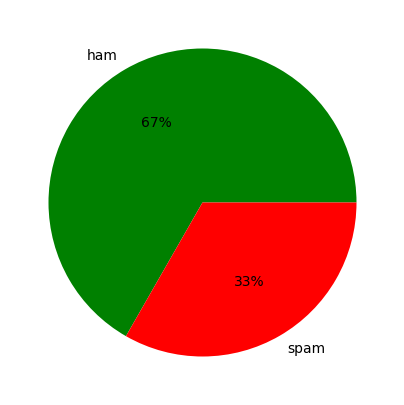

In [12]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['green', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()

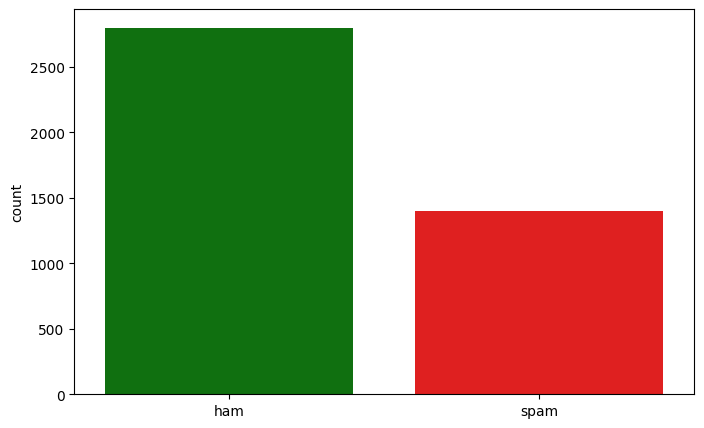

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors)
plt.show()

In [14]:
def plot_WordCloud(text_list):
    unique_string=(" ").join(text_list)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

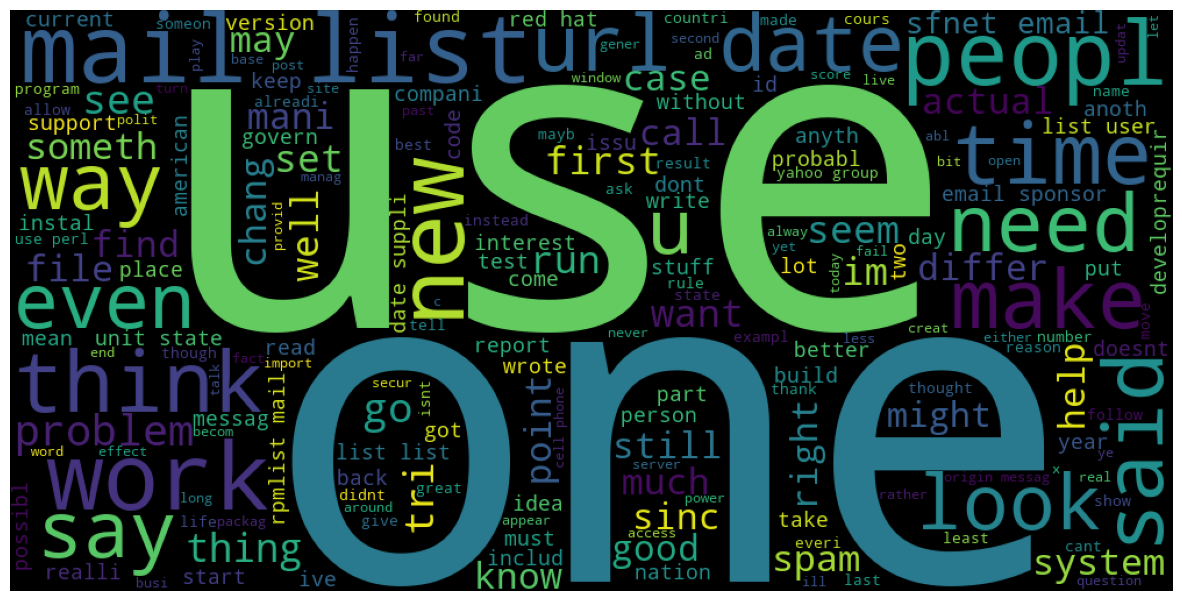

In [15]:
plot_WordCloud(text_easy_ham)

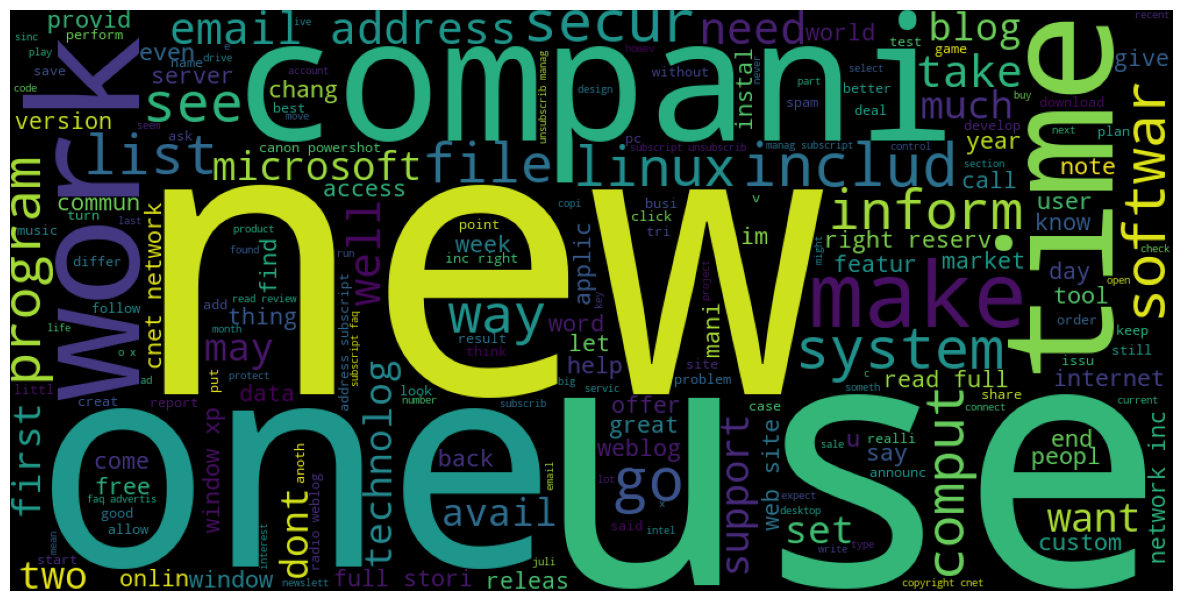

In [16]:
plot_WordCloud(text_hard_ham)

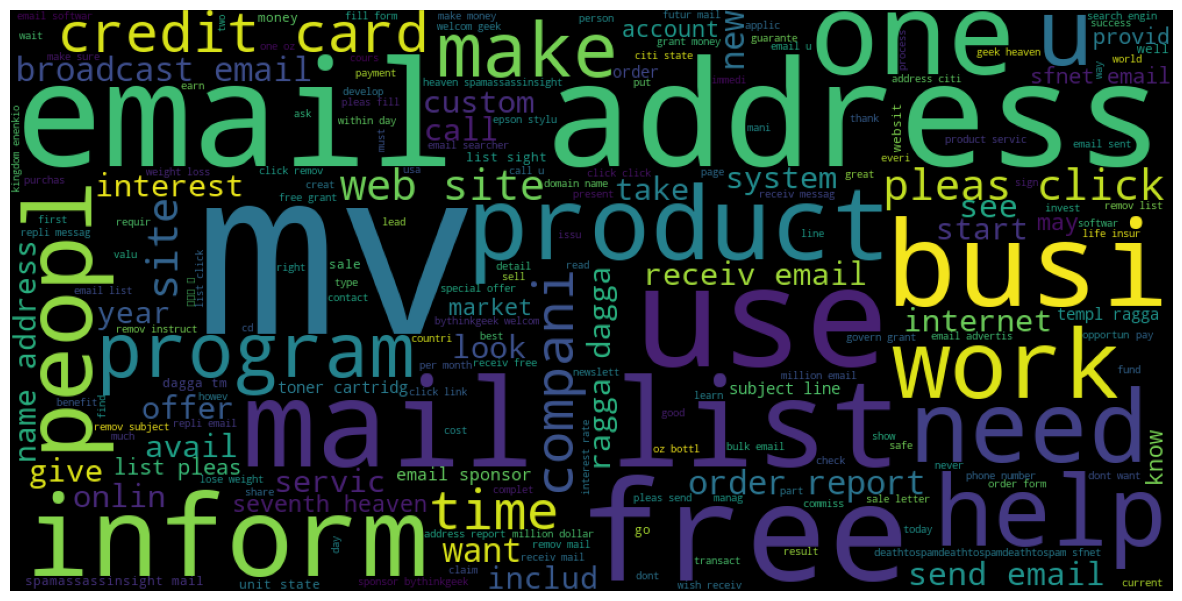

In [17]:
plot_WordCloud(text_spam)

Splitting dataset

In [18]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

email_texts = text_ham + text_spam
labels = ['ham'] * len(text_ham) + ['spam'] * len(text_spam)

lb = LabelBinarizer()
label_list = lb.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(email_texts, label_list, test_size=0.1, random_state=42)


VECTORIZATION

In [19]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)

CountVectorizer(stop_words='english')

In [20]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [21]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [22]:
import pickle

# Save email_texts and label_list
with open('email_texts.pkl', 'wb') as f:
    pickle.dump(email_texts, f)

with open('label_list.pkl', 'wb') as f:
    pickle.dump(label_list, f)

print("Data saved as pickle files.")

Data saved as pickle files.


In [23]:
with open('email_texts.pkl', 'rb') as f:
    email_texts = pickle.load(f)

with open('label_list.pkl', 'rb') as f:
    label_list = pickle.load(f)

print("Data loaded from pickle files.")



X_train, X_test, y_train, y_test = train_test_split(email_texts, label_list, test_size=0.1, random_state=42)



Data loaded from pickle files.
